In [1]:
import sqlite3
import pandasql as ps

import pandas as pd
import numpy as np

import openpyxl

import plotnine as p9

import warnings
warnings.filterwarnings('ignore')

In [2]:
OUT_PATH = 'D:/fvs_calibration/data/interim'

In [3]:
#read in FIA source tables 
DB_PATH = 'D:FIA/FIADB_CA.db'

con = sqlite3.connect(DB_PATH)
# grab fvs_standinit_cond, cond, tree tables, and tree remeasurement table
stands = pd.read_sql_query("select STAND_CN, STAND_ID, INV_YEAR, REGION, FOREST from FVS_STANDINIT_COND where VARIANT = 'NC'", con)
cond = pd.read_sql_query("select CN, PLT_CN, CONDID, DSTRBCD1, TRTCD1 from COND", con)
trees = pd.read_sql_query("select CN AS TRE_CN, PLT_CN, CONDID, INVYR, TREE, STATUSCD, TPA_UNADJ, SPCD, DIA, HT, VOLCFNET, VOLCFGRS from TREE", con)


Keys can be confusing here:
* STAND_CN - fvs_standinit_cond id (relates to cond.cn) - unique to each condition/year
* STAND_ID - fvs_standinit_cond fvs ID (no relations in FIA) - unique to each condition/year
* CN - cond id (no relations in FIA) - unique to each condition/year
* PLT_CN - plot id (relates to tree.plot_cn) - unique to plot/year
* CONDID - condition id (plt_cn & condid can relate to cond to tree table) 
* STAND_ID2 - calculated field - strips STAND_ID of time data - unique to each condition (not year)
* TRE_CN - tree specific id, changes between remeasurement years. 

In [4]:
# some pre-processing
# convert inv_year to integer
stands['INV_YEAR'] = stands['INV_YEAR'].astype(int)
# scrape stand_id so remeasurement ids match
stands['STAND_ID2'] = stands['STAND_ID'].str[0:3] + stands['STAND_ID'].str[10:]
# create key matrix
cond_id = cond[['CN', 'PLT_CN', 'CONDID']]

In [5]:
# identify stands that have had no disturbance or harvest
stands_nodisturb = ps.sqldf("""select *
                               from stands s 
                               join cond c 
                               on s.STAND_CN = c.CN 
                               WHERE (c.DSTRBCD1 = NULL OR c.DSTRBCD1 = 0)
                               AND (c.TRTCD1 = NULL OR c.TRTCD1 = 0)
                          """)

In [6]:
# further filter out stands that don't have remeasurement data 
stands = stands_nodisturb.sort_values(by=['STAND_ID', 'STAND_ID2', 'INV_YEAR', 'REGION', 'FOREST'])
stands_filtered = stands[stands.duplicated(subset=['STAND_ID2'], keep=False)]

In [76]:
# use cond key matrix to get plt_cn to match with trees and stand table
trees_id = trees.merge(cond_id, how='left', on=['PLT_CN', 'CONDID'])
# join nodisturb stands with tree records to filter 
stands_filtered_cn = stands_filtered[['CN', 'REGION', 'FOREST']]
trees_filtered = trees_id.merge(stands_filtered_cn, how='inner', on='CN')
trees_filtered = trees_filtered[['CN', 'PLT_CN', 'CONDID', 'TRE_CN', 'TREE', 'INVYR', 'STATUSCD', 'TPA_UNADJ', 'REGION', 'FOREST', 'SPCD', 'DIA', 'HT', 'VOLCFGRS']]
trees_filtered.head(1)

,CN,PLT_CN,CONDID,TRE_CN,TREE,INVYR,STATUSCD,TPA_UNADJ,REGION,FOREST,SPCD,DIA,HT,VOLCFGRS
0,23652219010900,23652215010900,1,23652246010900,100,2001,1,6.018046,5.0,10.0,631.0,7.0,41.0,2.864269


In [77]:
# export to excel for use in National Volume Estimator Library (NVEL)
trees_filtered.to_excel(OUT_PATH + '/NC_trees_for_NVEL.xlsx')

Calculate volume estimates in NVEL. Save updated workbook as NC_trees_for_NVEL_calc
* ['EQUATION'] = '=VolumeEquationNumber(L2,M2,1,N2,2)' 
* ['VOLUME_CVTS'] = '=calcFiaVol(R2,N2,O2,P2,,"CVTS")'
* ['VOLCALC_CV4'] = '=calcFiaVol(R2,N2,O2,P2,,"CV4")'

In [101]:
# read in nvel volume tree records
volume_calc = pd.read_excel(OUT_PATH + '/NC_trees_for_NVEL_calc.xlsx' )

In [102]:
# add key values to volume_calc
volume_calc['CN'] = volume_calc['CN'].astype(str)
stands_filtered_id = stands_filtered[['CN', 'STAND_ID', 'STAND_ID2']]
volume_calc = volume_calc.merge(stands_filtered_id, on = 'CN')

In [103]:
# print stand_id values for a sample set of conditions to run through FVS for QA
stands_2009 = list(stands_filtered.loc[stands_filtered['INV_YEAR'] == 2009, 'STAND_ID'].unique())[0:5]
stands_2019 = list(stands_filtered.loc[stands_filtered['INV_YEAR'] == 2019, 'STAND_ID'].unique())[0:5]
print('2009 stands_ids:', stands_2009)
print('2019 stands_ids:', stands_2019)

2009 stands_ids: ['00062008050801015612061', '00062008050801045526391', '00062008050801045652731', '00062008050801045666311', '00062008050801045708691']
2019 stands_ids: ['00062018060804053658631', '00062019060901015535191', '00062019060901015607491', '00062019060901015636761', '00062019060901015759701']


Run two scenarios through FVS to get FVS volume estimates for measurement year (stand and tree level)
* Run 1: 2009 stands run 2009 to 2019 
* Run 2: 2019 stands run 2019 to 2029

In [104]:
# join FVS tree volume estimates
#read in FVS output
DB_PATH = 'D:/fvs_calibration/data/interim/FVSOut.db'
con2 = sqlite3.connect(DB_PATH)
fvs_trees = pd.read_sql_query("select CaseID, StandID, Year, TreeId, SpeciesFIA, TreeVal, TCuFt, MortPA from FVS_TreeList", con2)
fvs_cases = pd.read_sql_query("select CaseID, StandID, MgmtID from FVS_Cases", con2)

# add scenario description from cases table
fvs_trees = fvs_trees.merge(fvs_cases, on=("StandID", "CaseID"))

fvs_trees['TreeId'] = fvs_trees['TreeId'].astype('int64')
sub_fvs_trees = fvs_trees.loc[((fvs_trees["MgmtID"] == 'Run1') & (fvs_trees["Year"] == 2009)) | ((fvs_trees["MgmtID"] == 'Run2') & (fvs_trees["Year"] == 2019))]
sub_fvs_trees = sub_fvs_trees[['StandID', 'Year', 'TreeId', 'TreeVal', 'TCuFt', 'MgmtID']]

volume_calc_join = sub_fvs_trees.merge(volume_calc, how="left", left_on=("StandID", "Year", "TreeId"), right_on=("STAND_ID", "INVYR", "TREE"))

In [105]:
print(sub_fvs_trees.shape[0])
print(volume_calc_join.shape[0])

380
394


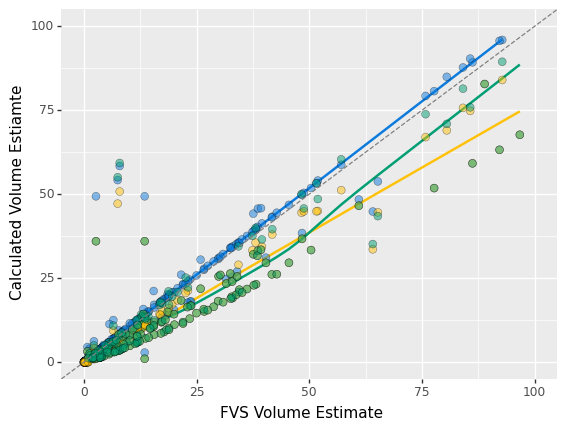

<ggplot: (180429087384)>

In [72]:
(p9.ggplot(volume_calc_join)
    + p9.geom_smooth(mapping = p9.aes(x = 'TCuFt', y ='VOLUME_CV4'), color="#FFC20A", se = False)
    + p9.geom_smooth(mapping = p9.aes(x = 'TCuFt', y ='VOLUME_CVTS'), color="#0C7BDC", se = False)
    + p9.geom_smooth(mapping = p9.aes(x = 'TCuFt', y ='VOLCFGRS'), color="#009E73", se = False)
    + p9.geom_point(mapping = p9.aes(x = 'TCuFt', y ='VOLUME_CVTS'), fill='#0C7BDC', alpha = .5, stroke=.2, size=3)
    + p9.geom_point(mapping = p9.aes(x = 'TCuFt', y ='VOLUME_CV4'), fill='#FFC20A' , alpha = .5, stroke=.2, size=3)
    + p9.geom_point(mapping = p9.aes(x = 'TCuFt', y ='VOLCFGRS'), fill='#009E73' , alpha = .5, stroke=.2, size=3)
    + p9.geom_abline(slope = 1, intercept = 0, linetype="dashed", color="Grey")
    + p9.scale_x_continuous(limits = (0, 100))
    + p9.scale_y_continuous(limits = (0, 100))
    + p9.xlab("FVS Volume Estimate")
    + p9.ylab("Calculated Volume Estiamte"))

#Blue - Volume CVTS
#Yellow - Volume CV4
#Green - FIA

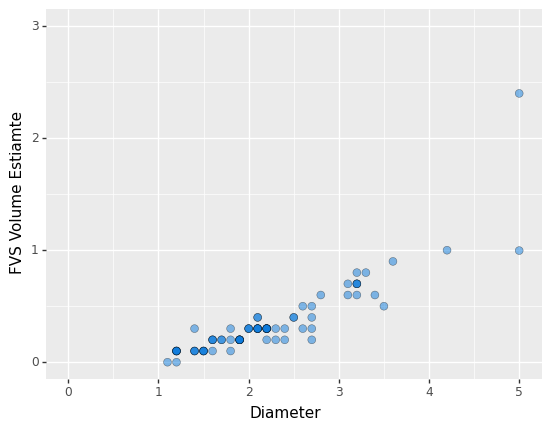

<ggplot: (180428747882)>

In [106]:
# check to see what trees FVS is calculating volume for (re: diameter)
(p9.ggplot(volume_calc_join)
    + p9.geom_point(mapping = p9.aes(x = 'DIA', y ='TCuFt'), fill='#0C7BDC', alpha = .5, stroke=.2, size=3)
    + p9.scale_x_continuous(limits = (0, 5))
    + p9.scale_y_continuous(limits = (0, 3))
    + p9.xlab("Diameter")
    + p9.ylab("FVS Volume Estiamte"))


The NVEL calculation using CVTS volume type most closely matches FVS volume estimates. 

Let's calculate some Accretion and Mortality values from the NVEL treelist (subset to stands run through FVS) and compare to FVS estimates

In [107]:
# sum tree volume estimates to stand level for nvel and fvs calcuated (tree level) volume estimates. 
# bin by live and dead trees
nvel_vol_agg = volume_calc_join.groupby(['STAND_ID2', 'Year', 'STATUSCD'], as_index=False).agg({'VOLUME_CVTS': 'sum', 'TCuFt': 'sum'}).rename(columns={'VOLUME_CVTS': 'cvts', 'TCuFt': 'tcuft'})
#nvel_vol_agg['StandID'] = nvel_vol_agg['StandID'].str[0:3] + nvel_vol_agg['StandID'].str[10:]
nvel_vol_agg['STATUSCD'] = np.where(nvel_vol_agg['STATUSCD'] == 1, 'Acc', 'Mort')
nvel_vol_agg['Year'] = nvel_vol_agg['Year'].apply(str)

In [108]:
# create 'acc' and 'mort' estimates by stand 
vol_agg = nvel_vol_agg.pivot_table(index=['STAND_ID2'], columns = ['Year', 'STATUSCD'])
vol_agg.columns = vol_agg.columns.map('_'.join)
vol_agg = vol_agg.reset_index() 
vol_agg = vol_agg.fillna(0)

vol_agg['mort_tcuft'] = vol_agg['tcuft_2019_Mort'] - vol_agg['tcuft_2009_Mort']
vol_agg['mort_cvts'] = vol_agg['cvts_2019_Mort'] - vol_agg['cvts_2009_Mort']
vol_agg['acc_tcuft'] = vol_agg['tcuft_2019_Acc'] - vol_agg['tcuft_2009_Acc']
vol_agg['acc_cvts'] = vol_agg['cvts_2019_Acc'] - vol_agg['cvts_2009_Acc']

vol_agg.drop(vol_agg.iloc[:, 1:9], axis=1, inplace=True)

In [112]:
# compare that to the summary table from FVS

# grab summary table
fvs_summary = pd.read_sql_query("select CaseID, StandID, Year, Tpa, TCuFt, Mort, Acc from FVS_Summary2", con2)

# add scenario description from cases table
fvs_summary = fvs_summary.merge(fvs_cases, on=("StandID", "CaseID"))
sub_fvs_summary = fvs_summary.loc[((fvs_summary["MgmtID"] == 'Run1') & (fvs_summary["Year"] == 2009)) | ((fvs_summary["MgmtID"] == 'Run2') & (fvs_summary["Year"] == 2019))]

sub_fvs_summary['STAND_ID2'] = sub_fvs_summary['StandID'].str[0:3] + sub_fvs_summary['StandID'].str[10:]
#sub_fvs_summary['STAND_ID2'] = sub_fvs_summary['STAND_ID2'].astype('int64')

sub_fvs_summary = sub_fvs_summary[['STAND_ID2', 'Year', 'TCuFt']]
sub_fvs_summary['Year'] = sub_fvs_summary['Year'].apply(str)

fvs_agg = sub_fvs_summary.pivot_table(index=['STAND_ID2'], columns = ['Year'])
fvs_agg.columns = fvs_agg.columns.map('_'.join)
fvs_agg = fvs_agg.reset_index()

fvs_agg['acc_summary'] = fvs_agg['TCuFt_2019'] - fvs_agg['TCuFt_2009']

# join with vol_agg
all_agg = fvs_agg.merge(vol_agg, on='STAND_ID2')
all_agg = all_agg[['STAND_ID2', 'acc_summary', 'acc_tcuft', 'acc_cvts', 'mort_tcuft','mort_cvts']]
all_agg

,STAND_ID2,acc_summary,acc_tcuft,acc_cvts,mort_tcuft,mort_cvts
0,0000901015535191,894.103516,1149.294520,1194.272985,86.299458,210.369774
1,0000901015607491,55.226715,7.817280,16.156773,-6.043152,-8.007966
2,0000901015636761,948.535889,974.179340,973.535250,183.096284,190.675975
3,0000901015759701,-4781.324219,-1323.169085,-1350.451957,1189.509584,1211.564472
4,0000901015759702,2810.141113,638.709375,643.510135,-25.708623,-44.003150


In [113]:
# compare all that to the Acc and Mort Values calcuated for our simulated scenario (Run1)
sub_fvs_summary2 = fvs_summary.loc[((fvs_summary["MgmtID"] == 'Run1') & (fvs_summary["Year"] == 2009))]

sub_fvs_summary2['STAND_ID2'] = sub_fvs_summary2['StandID'].str[0:3] + sub_fvs_summary2['StandID'].str[10:]
#sub_fvs_summary2['STAND_ID2'] = sub_fvs_summary2['STAND_ID2'].astype('int64')

sub_fvs_summary2 = sub_fvs_summary2[['STAND_ID2', 'Acc', 'Mort']]

sub_fvs_summary2['Mort'] = sub_fvs_summary2['Mort'] * 10
sub_fvs_summary2['Acc'] = sub_fvs_summary2['Acc'] * 10 + sub_fvs_summary2['Mort']

all_agg2 = sub_fvs_summary2.merge(all_agg, on='STAND_ID2')
all_agg2

,STAND_ID2,Acc,Mort,acc_summary,acc_tcuft,acc_cvts,mort_tcuft,mort_cvts
0,0000901015535191,2220.449810,24.310589,894.103516,1149.294520,1194.272985,86.299458,210.369774
1,0000901015607491,444.177623,1.616359,55.226715,7.817280,16.156773,-6.043152,-8.007966
2,0000901015636761,1220.928001,94.050255,948.535889,974.179340,973.535250,183.096284,190.675975
3,0000901015759701,8991.853943,8302.581177,-4781.324219,-1323.169085,-1350.451957,1189.509584,1211.564472
4,0000901015759702,1880.180819,26.861727,2810.141113,638.709375,643.510135,-25.708623,-44.003150


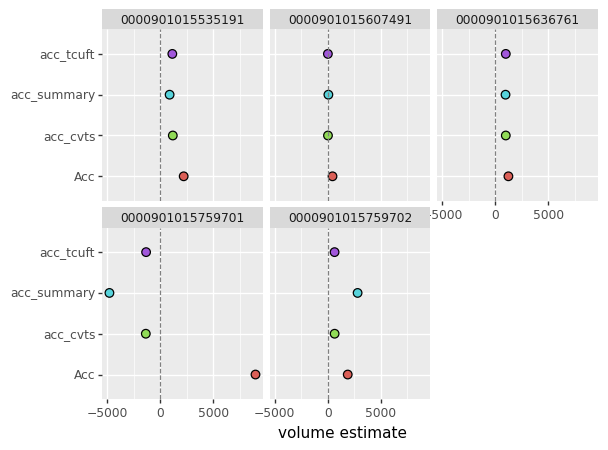

<ggplot: (180448553831)>

In [114]:
all_agg2_melt = pd.melt(all_agg2, id_vars=['STAND_ID2'])
all_agg2_acc = all_agg2_melt[all_agg2_melt['variable'].isin(['Acc', 'acc_summary', 'acc_tcuft', 'acc_cvts'])]

(p9.ggplot(all_agg2_acc, mapping = p9.aes(x = 'value', y ='variable', fill='variable'))
    + p9.geom_point(size = 3)
    + p9.facet_wrap('STAND_ID2')
    + p9.geom_vline(xintercept=0, linetype="dashed", color="Grey")
    + p9.scale_fill_discrete(guide=False)
    + p9.xlab("volume estimate")
    + p9.ylab("")
)

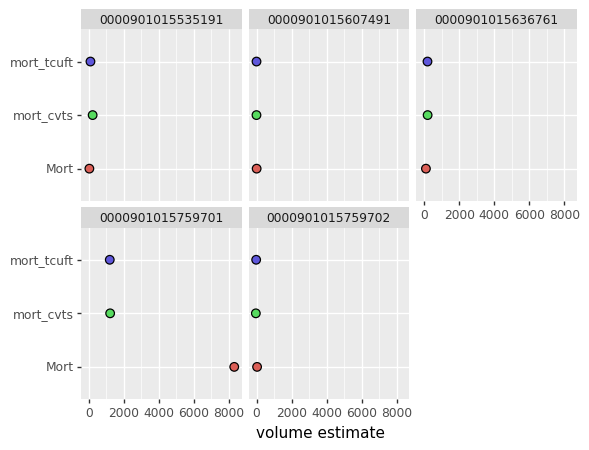

<ggplot: (180446504921)>

In [115]:
all_agg2_mort = all_agg2_melt[all_agg2_melt['variable'].isin(['Mort', 'mort_tcuft', 'mort_cvts'])]

(p9.ggplot(all_agg2_mort, mapping = p9.aes(x = 'value', y ='variable', fill='variable'))
    + p9.geom_point(size = 3)
    + p9.facet_wrap('STAND_ID2')
    #+ p9.geom_vline(xintercept=0, linetype="dashed", color="Grey")
    + p9.scale_fill_discrete(guide=False)
    + p9.xlab("volume estimate")
    + p9.ylab("")
)

Upon examining the FIA tree list between two remeasurement years - trees 'fall out' of the treelist.  Dead trees present in year 2001 are not necessarily present in year 2011 (though they sometimes are). Hence why we are seeing some negative mortality values between years. 

Need to explore another way of calculating mortality values. 
Let's explore the TREE_GRM_ESTN (Tree Net Growth, REmoval, and Mortality Estimation Table) table. 

In [116]:
# grab TREE_GRM_ESTN table
# TPAGROW_UNADJ
sql = """select TRE_CN, PREV_TRE_CN, PLT_CN, STEM_COMPONENT, MICR_TPAGROW_UNADJ_AL_FOREST, MICR_TPAMORT_UNADJ_AL_FOREST, GROWCFAL_FOREST, MORTCFAL_FOREST 
        from TREE_GRM_COMPONENT WHERE STEM_COMPONENT IN ('MORTALITY1', 'SURVIVOR')"""
tree_grm = pd.read_sql_query(sql, con)
print(tree_grm['STEM_COMPONENT'].unique())
print(tree_grm.shape[0])

['MORTALITY1' 'SURVIVOR']
122794


COMPONENT TYPES OF INTEREST:
* INGROWTH: Tree grew across minimum threshold diameter for estimate since time 1. (5 in threshold) - NOT INCLUDED CURRENTLY
* MORTALITY1 : Tree was previously in time 1 and died of natual causes by T2
* SURVIOVOR: Tree has remained alove and in the estimate from T1 through T2


In [128]:
# filter by stands in the volume_calc_join table (trees run through FVS)
tree_grm['PLT_CN'] = tree_grm['PLT_CN'].astype('float64')
tree_grm['TRE_CN'] = tree_grm['TRE_CN'].astype('float64')

volume_calc_join_id = volume_calc_join[['PLT_CN', 'TRE_CN', 'STAND_ID2']]

tree_grm_filter = tree_grm.merge(volume_calc_join_id, how='inner', on = ['PLT_CN', 'TRE_CN'])
tree_grm_filter.head(1)

,TRE_CN,PREV_TRE_CN,PLT_CN,STEM_COMPONENT,MICR_TPAGROW_UNADJ_AL_FOREST,MICR_TPAMORT_UNADJ_AL_FOREST,GROWCFAL_FOREST,MORTCFAL_FOREST,STAND_ID2
0,7.230136e+14,734629010497,5.586264e+14,SURVIVOR,0.999188,0.0,0.752869,0.0,0000901015759701


In [138]:
# sum tree_grm values by stand
# first make survivor table and mort tables
survive = tree_grm_filter.loc[tree_grm_filter['STEM_COMPONENT'] == 'SURVIVOR']
survive['ex_GROWCFAL_FOREST'] = (survive['MICR_TPAGROW_UNADJ_AL_FOREST']*survive['GROWCFAL_FOREST'])*10
mortality = tree_grm_filter.loc[tree_grm_filter['STEM_COMPONENT'] == 'MORTALITY1']
mortality['ex_MORTCFAL_FOREST'] = (mortality['MICR_TPAMORT_UNADJ_AL_FOREST']*mortality['MORTCFAL_FOREST'])*10

survive_grm = survive.groupby(['STAND_ID2'], as_index=False).agg({'ex_GROWCFAL_FOREST': 'sum'}).rename(columns={'ex_GROWCFAL_FOREST': 'grow_sum'})
mort_grm = mortality .groupby(['STAND_ID2'], as_index=False).agg({'ex_MORTCFAL_FOREST': 'sum'}).rename(columns={'ex_MORTCFAL_FOREST': 'mort_sum'})

agg_grm = survive_grm.merge(mort_grm, how = 'left', on='STAND_ID2')
agg_grm

,STAND_ID2,grow_sum,mort_sum
0,0000901015535191,745.202049,488.705361
1,0000901015607491,51.521305,NaN
2,0000901015636761,362.887031,227.777766
3,0000901015759701,424.864836,1166.770643
4,0000901015759702,802.350711,58.956745


In [145]:
# add grm calcs to the other volume calcs
all_agg3 = agg_grm.merge(all_agg2, on='STAND_ID2')
all_agg_acc = all_agg3[['STAND_ID2', 'grow_sum', 'Acc', 'acc_summary', 'acc_tcuft', 'acc_cvts']]
all_agg_mort = all_agg3[['STAND_ID2', 'mort_sum', 'Mort', 'mort_tcuft', 'mort_cvts']]


Accreation estimates descriptions:
* **grow_sum**: sum of (tree level gross tcuft volume change between remeasurement years * tpa expansion) * cycle length(10)
* **Acc**: (FVS_Summary Accretion value - estimated from simulation (not actual growth)) * cycle length(10)
* **acc_summary**: Difference in FVS_Summary TCuFt values from two time steps (FIA tree lists at each cycle, no simulated growth)
* **acc_tcuft**: Difference in summed tree tcuft values as calcuated by FVS, for live trees, from two time steps (FIA tree lists input to FVS at each cycle, no simulated growth)
* **acc_cvts**: Difference in summed tree tcuft values as calcuated by NVEL, for live trees, from two time steps

In [144]:
all_agg_acc

,STAND_ID2,grow_sum,Acc,acc_summary,acc_tcuft,acc_cvts
0,0000901015535191,745.202049,2220.449810,894.103516,1149.294520,1194.272985
1,0000901015607491,51.521305,444.177623,55.226715,7.817280,16.156773
2,0000901015636761,362.887031,1220.928001,948.535889,974.179340,973.535250
3,0000901015759701,424.864836,8991.853943,-4781.324219,-1323.169085,-1350.451957
4,0000901015759702,802.350711,1880.180819,2810.141113,638.709375,643.510135


Mortality estimates descriptions:
* **mort_sum**: sum of (tree level gross tcuft volume change between remeasurement years * tpa expansion) * cycle length(10)
* **Mort**: (FVS_Summary Accretion value - estimated from simulation (not actual growth)) * cycle length(10)
* **mort_tcuft**: Difference in summed tree tcuft values as calcuated by FVS, for dead trees, from two time steps (FIA tree lists input to FVS at each cycle, no simulated growth)
* **mort_cvts**: Difference in summed tree tcuft values as calcuated by NVEL, for dead trees, from two time steps

In [146]:
all_agg_mort

,STAND_ID2,mort_sum,Mort,mort_tcuft,mort_cvts
0,0000901015535191,488.705361,24.310589,86.299458,210.369774
1,0000901015607491,NaN,1.616359,-6.043152,-8.007966
2,0000901015636761,227.777766,94.050255,183.096284,190.675975
3,0000901015759701,1166.770643,8302.581177,1189.509584,1211.564472
4,0000901015759702,58.956745,26.861727,-25.708623,-44.003150


FVS calcuations for Mort and Acc values
* **Acc**: ((stand.tcuft(T2) - stand.tcuft(T1))/cycle length) + Mort
* **Mort**: sum(tree.morttpa * tree.tcuft)/cycle length

Things left to explore:
* Nvel tree values expanded by TPA_unadj

Right now looks like:
* Accretion: Compare FVS derived - acc_tcuft to FIA NVEL derived - acc_cvts
* Mortality: ?

Could explore other growth and mortality metrics - as proposed in methods write-up:

Growth metrics:
* Basal area increment by dbh class and species - likely will be used for calibration as it is directly correlated to the input used in the modifier keywords. 
* Volume (or incremental cubic or scribner volume growth) by dbh class and species
* Tree-level dbh increment or basal area increment

Mortality metrics:
* Mortality tpa by dbh class and species


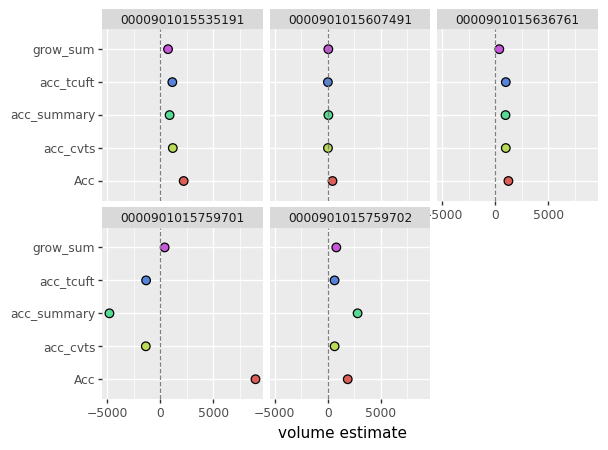

<ggplot: (180450896942)>

In [134]:
all_agg3_melt = pd.melt(all_agg3, id_vars=['STAND_ID2'])
all_agg3_acc = all_agg3_melt[all_agg3_melt['variable'].isin(['grow_sum','Acc', 'acc_summary', 'acc_tcuft', 'acc_cvts'])]

(p9.ggplot(all_agg3_acc, mapping = p9.aes(x = 'value', y ='variable', fill='variable'))
    + p9.geom_point(size = 3)
    + p9.facet_wrap('STAND_ID2')
    + p9.geom_vline(xintercept=0, linetype="dashed", color="Grey")
    + p9.scale_fill_discrete(guide=False)
    + p9.xlab("volume estimate")
    + p9.ylab("")
)